In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sc
import scipy
import matplotlib
from scipy.spatial.distance import pdist,squareform
from sklearn import*
def fix_plot(ax):
    ax.tick_params(which="minor", direction="in", length=3, width=1.3,)
    ax.tick_params(which="major", direction="in", length=6, width=1.3)
    ax.tick_params(which="minor", direction="in", length=3, width=1.3,)
    ax.tick_params(which="major", direction="in", length=6, width=1.3)
    plt.setp(ax.spines.values(), linewidth=1.3)
    plt.setp(ax.spines.values(), linewidth=1.3)

In [8]:
pos_flat = np.loadtxt('lj10clusters.txt')
positions = pos_flat.reshape(-1,pos_flat.shape[1]//2,2)

class LennardJones():
    def __init__(self,eps0=5,sigma=2**(-1/6)):
        self.eps0 = eps0
        self.sigma = sigma
        
    def _V(self,r):
        return 4*self.eps0*((self.sigma/r)**12 - (self.sigma/r)**6)

    def energy(self, pos): #pos must have shape MxN, where M is the number of particles, and N is the dimension of the space which they occupy
        return np.sum(self._V(pdist(pos)))
potential = LennardJones()

## Distance Moments Representation

In representing an atomic cluster of 2N cartesian coordinates, we can reduce the dimensionality of the representation from that of cartesian coordinates while keeping most uniqueness, with other representations such as the distance moments representation.

This representation is 2-dimensional, such that one atomic cluster has just two coordinates.

The two "coordinates" are the mean interatomic distance $\mu$ and the standard deviation of the interatomic distance $\sigma$

The following class is able to take a set of cartesian coordinates calculate this representation.

In [72]:
# The purpose of this class is to be able to sort lennard-Jones clusters of atoms into Clusters. One cluster may contain some information about it, other than the contained lj-clusters
class Cluster():
    def __init__(self, ljs):
        self._lj_clusters = ljs # This should just be a list of positions
    
    def add_lj_cluster(self, lj):
        self._lj_clusters.append(lj)

    def add_lj_clusters(self, ljs):
        for lj in ljs:
            self._lj_clusters.append(lj)

    @property
    def lj_clusters(self):
        return self._lj_clusters
    

In [10]:
# This class will allow us to add other Representations than the Distance Moments representation, with similar methods for plotting results, etc.
class Representation:
    def __init__(seflf):
        pass

    def descriptor(self, pos):
        raise LookupError("This representation has not implemented the descriptor method")

    def draw(self):
        raise LookupError("This representation has not implemented the draw method")
    
    def draw_descriptor_space(self, pos, ax, color):
        ax.set_title("Descriptor Space")
        vec = self.descriptor(pos)
        ax.scatter(vec[0], vec[1], color=color, alpha=0.6, s=400)
    
    def clustering(self, lj_clusters, no_of_clusters=6):
        vec_lengths = []
        for pos in lj_clusters:
            vec = self.descriptor(pos)
            vec_lengths.append(np.sqrt(vec[0]**2 + vec[1]**2))

        dmin = min(vec_lengths)
        dmax = max(vec_lengths)
        ls = np.linspace(dmin*0.95, dmax*1.1, no_of_clusters+1)

        clusters = [Cluster([poss for poss in lj_clusters if ls[i] < np.sqrt(self.descriptor(poss)[0]**2 + self.descriptor(poss)[1]**2) < ls[i+1]]) for i in range(no_of_clusters)]
        return clusters

In [11]:
# This class can perform clustering with the Distance Moments Representation. It also has some drawing methods
class DistanceMoments(Representation):
    def __init__(self, color='indianred'):
        super().__init__()
        self.xwidth = 1
        self.color = color
        self.bin_centers = range(2)
    
    def descriptor(self,pos):
        all_distances = scipy.spatial.distance.pdist(pos)
        mean = np.mean(all_distances)
        std = np.std(all_distances)
        return np.array([mean,std])
    
    def draw(self,pos,ax):
        vector = self.descriptor(pos)
        ax.bar(self.bin_centers,vector,width=0.8 * self.xwidth,color=self.color, edgecolor='k')
        ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))
        ax.set_ylim([0,2.3])
        xticklabels = ['$\mu$','$\sigma$']
        ax.set_xticks(range(len(xticklabels)))
        ax.set_xticklabels(xticklabels)
        ax.set_title(self.__class__.__name__)

    def draw_descriptor_space(self, pos, ax, color):
        super().draw_descriptor_space(pos, ax, color)
        ax.set_xlabel(r"$\mu$", fontsize=14)
        ax.set_ylabel(r"$\sigma$", fontsize=14)


In [88]:
# This is a plotting class, which is able to produce certain kinds of plots that show the clustering of data
class ClusterPlotter():
    def __init__(self, clusters=[], colors=["wheat", "indianred", "royalblue", "red", "blue", "gold", "yellow", "turquoise", "navy", "violet", "pink", "green", "azure", "peru", "palegreen"]):
        if not isinstance(clusters, (np.ndarray, list)):
            raise TypeError("You must pass a list of clusters!")
        self._clusters = clusters
        self._colors = colors
        self._dm = DistanceMoments()

    
    def add_cluster(self, cluster):
        self._clusters.append(cluster)

    def add_clusters(self, clusters):
        if not isinstance(clusters, (np.ndarray, list)):
            raise TypeError("You must pass a list of clusters!")
        for cluster in clusters:
            self._clusters.append(cluster)

    def descriptor_plot(lj_clusters, representation, axs):
        no_of_rows = len(axs)
        no_of_columns = len(axs[0])
        if not isinstance(representation, Representation):
            if isinstance(representation, (list, np.ndarray)):
                no_of_columns = len(representation)
                for n in range(no_of_rows):
                    axs[n][0].plot(lj_clusters[n][:, 0], lj_clusters[n][:, 1], "o", markersize=15, markeredgecolor='k', mew=1.4, color="wheat")
                    axs[n][0].set_xlim(-4, 4)
                    axs[n][0].set_ylim(-4, 4)
                    axs[n][0].grid()
                    axs[n][0].set_title(f"E = {potential.energy(lj_clusters[n]):.5}")
                    for nn, r in zip(range(no_of_columns), representation):
                        axs[n][nn+1].grid()
                        r.draw(lj_clusters[n], axs[n][nn+1])
            else:
                raise TypeError("Not a proper Representation!")
        else:
            i = 0
            for n in range(no_of_rows):
                if no_of_columns%2 != 0: raise ValueError("Number of columns must be even for this plot!")
                for nn in range(int(no_of_columns/2)):
                    fix_plot(axs[n][2*nn]); fix_plot(axs[n][2*nn+1])
                    axs[n][2*nn].grid(); axs[n][2*nn+1].grid()
                    axs[n][2*nn].axis("equal"); #axs[n][2*nn+1].axis("equal")
                    axs[n][2*nn].set_xlim(-4, 4)
                    axs[n][2*nn].set_ylim(-4, 4)
                    axs[n][2*nn].set_title(f"E = {potential.energy(lj_clusters[i]):.5}")
                    axs[n][2*nn].plot(lj_clusters[i][:, 0], lj_clusters[i][:, 1], "o", markersize=15, markeredgecolor='k', mew=1.4, color="wheat")
                    representation.draw(lj_clusters[i], axs[n][2*nn+1])
                    i += 1

    def descriptor_space_plot(self, representation, ax, fig):
        for cluster, color in zip(self._clusters, self._colors):
            ljs = cluster.lj_clusters
            for lj in ljs:
                representation.draw_descriptor_space(lj, ax, color)
        cmap = matplotlib.colors.ListedColormap(self._colors[0:len(self._clusters)])
        norm = matplotlib.colors.Normalize(vmin=0, vmax=len(self._clusters))
        cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, ticks=[i + 1/2*(i+1 - i) for i in range(len(self._clusters))])
        cbar.ax.set_yticklabels([f"Cluster {n+1}" for n in range(len(self._clusters))])
        ax.grid()

    def lj_plot(self, axs):
        all_axes = []
        for ax in axs:
            for axx in ax:
                axx.axis("off")
                axx.axis("equal")
                axx.set_xlim(-4, 4)
                axx.set_ylim(-4, 4)
                all_axes.append(axx)
        i = 0
        for cluster, color in zip(self._clusters, self._colors):
            for these_positions in cluster.lj_clusters:
                all_axes[i].scatter(these_positions[:, 0], these_positions[:, 1], s=200, color=color, edgecolor='k')
                i += 1

### Let's plot a few clusters

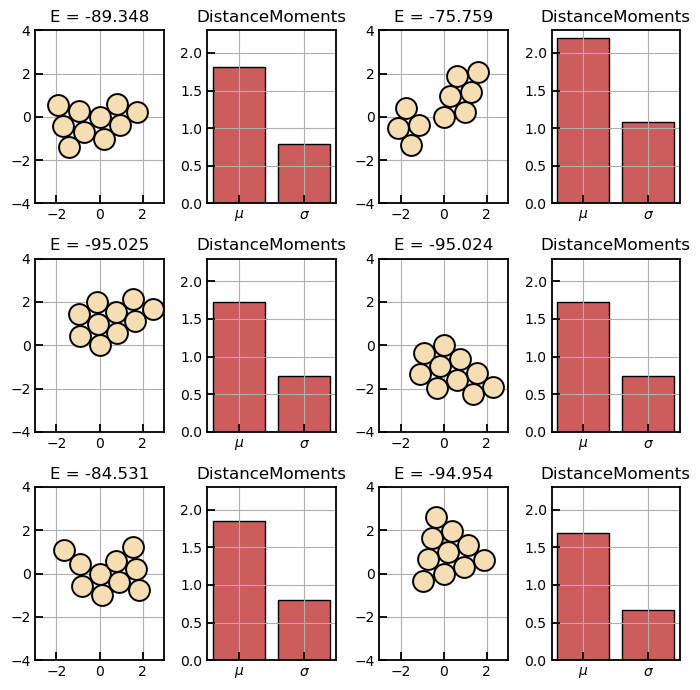

In [13]:
fig, axs = plt.subplots(3, 4, figsize=(7, 7))
dm = DistanceMoments()
ClusterPlotter.descriptor_plot(positions, dm, axs)
fig.tight_layout()

### Plot in Descriptor Space

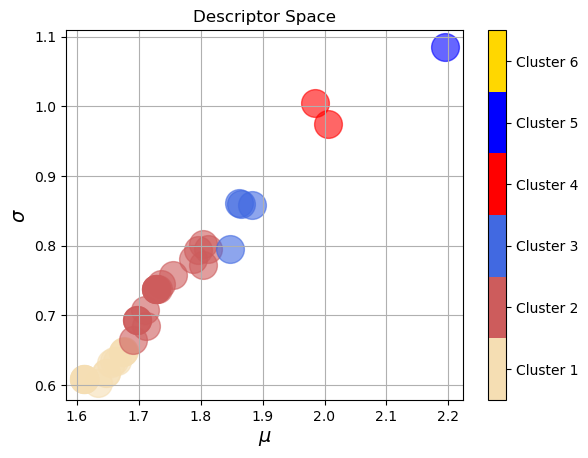

In [14]:
fig, ax = plt.subplots()
cls = dm.clustering(positions)
cpp = ClusterPlotter(cls)
cpp.descriptor_space_plot(dm, ax, fig)


### Clustering according to the distance moments representation

#### I have sorted the atomic clusters into 6 clusters in description space. This sorting is done based on the length of the vector in descriptor space. The first group has the lowest $\sqrt{\mu^2 + \sigma^2}$, and so on.

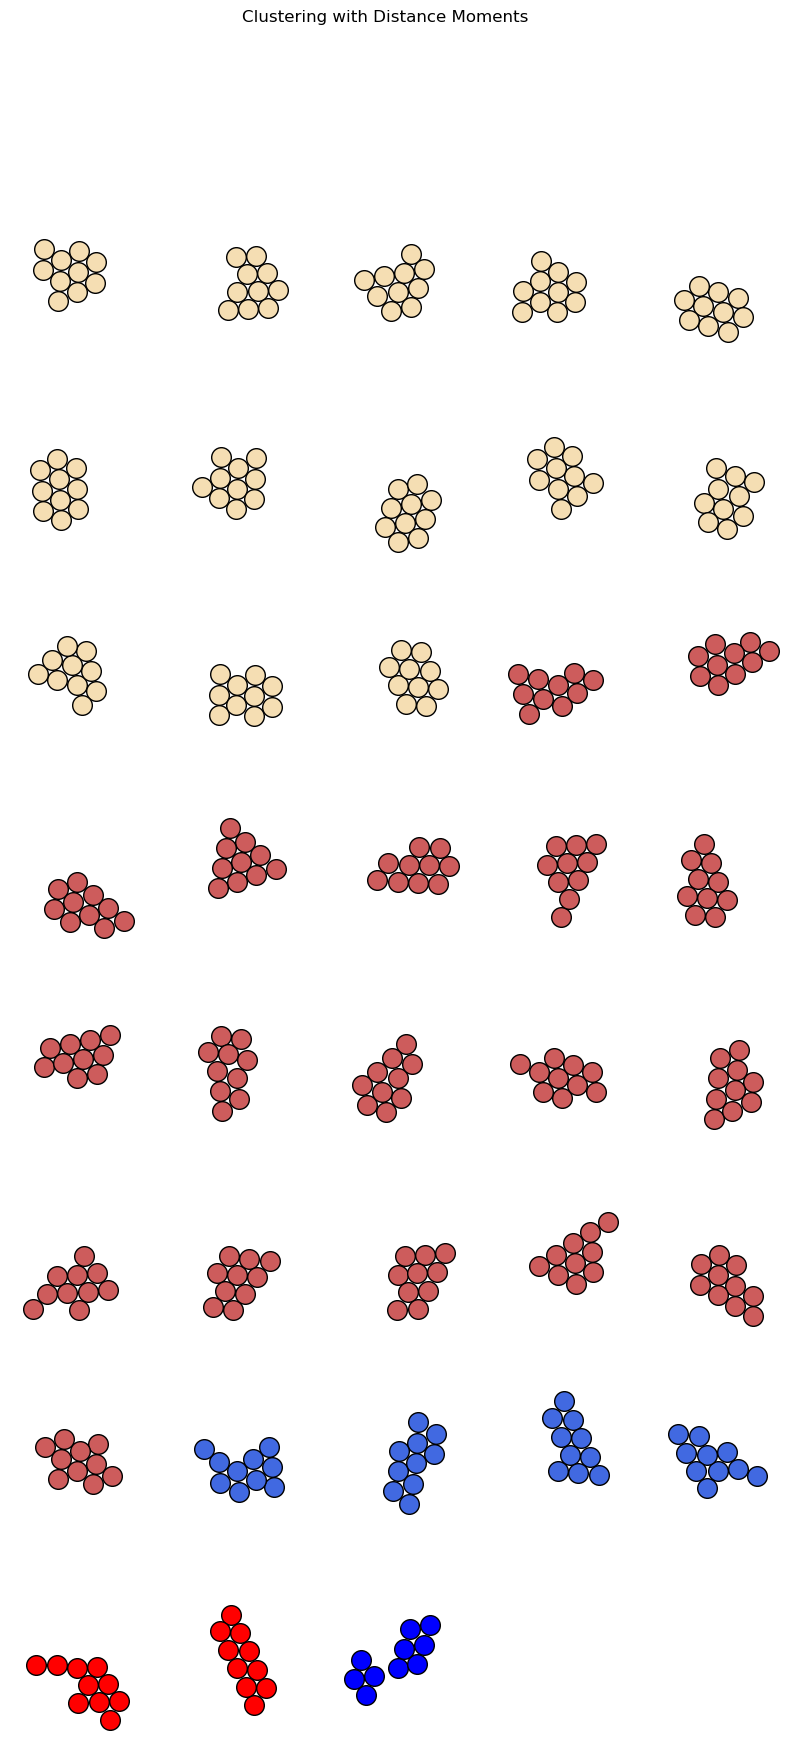

In [15]:
fig, axs = plt.subplots(8, 5, figsize=(10, 20))
fig.suptitle("Clustering with Distance Moments")
clusters = dm.clustering(positions)
cpp = ClusterPlotter(clusters)
cpp.lj_plot(axs)


#### Discussion:

This descriptor does seem somewhat useful. There is a clear pattern when looking through all atomic clusters, of which the first group ("cluster") members are more symmetric and generally more similar than that of the following clusters. This descriptor is also likely correlated with the energy of these configurations.

However, especially the last clusters allow for very different configurations to be placed into the same cluster. This may be fine in some cases (depending on the attributes of the configurations which we deem important/relevant), but may also result in not as useful clustering.

## Extreme Neighbor Count

Here, I implement the Extreme Neighbor Count representation. It should be easy with the already implemented classes.

In [16]:
class ExtremeNeighborCount(Representation):
    
    def __init__(self, color='C5'):
        self.xwidth = 1
        self.color = color
        self.bin_centers = range(2)
    
    def descriptor(self,pos, A=1.2, sigma=2**(-1/6)):
        all_distances = pdist(pos)
        r_cut = sigma*A*2**(1.0/6.0)
        Ns = []
        connectivity_matrix = (squareform(all_distances) <= r_cut).astype(int)
        np.fill_diagonal(connectivity_matrix, 0) #We set diagonal to zero, so that one particle is not counted as its own nearest neighbor
        for row in connectivity_matrix:
            Ns.append(sum(row))
        Nlowest = min(Ns)
        Nhighest = max(Ns)
        return np.array([Nlowest,Nhighest])

    def draw(self,pos,ax):
        vector = self.descriptor(pos)
        ax.bar(self.bin_centers,vector,width=0.8 * self.xwidth,color=self.color, edgecolor='k')
        ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))
        ax.set_ylim([0,7])
        xticklabels = ['$N_{min}$','$N_{max}$']
        ax.set_xticks(range(len(xticklabels)))
        ax.set_xticklabels(xticklabels)
        ax.set_title(self.__class__.__name__)

    def draw_descriptor_space(self, pos, ax, color):
        super().draw_descriptor_space(pos, ax, color)
        ax.set_xlabel(r"$N_{lowest}$", fontsize=14)
        ax.set_ylabel(r"$N_{highest}$", fontsize=14)

    #Just to remind us, that sometimes the clustering method will have to be overridden:
    def clustering(self, lj_clusters, no_of_clusters=6):
        vecs = []
        for pos in lj_clusters:
            vec = self.descriptor(pos)
            if not list(vec) in vecs:
                vecs.append(list(vec))

        clusters = [Cluster([poss for poss in lj_clusters if list(self.descriptor(poss)) == vec]) for vec in vecs]
        return clusters

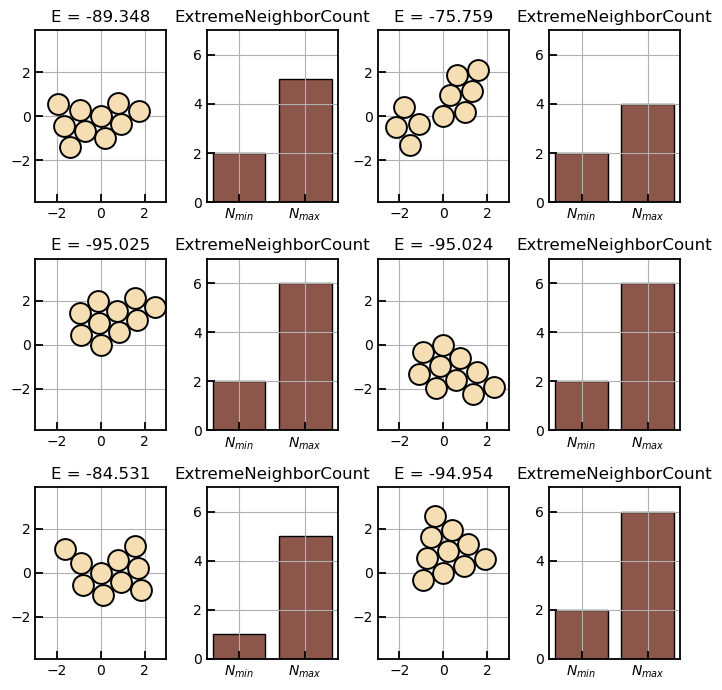

In [17]:
fig, axs = plt.subplots(3, 4, figsize=(7, 7))
dme = ExtremeNeighborCount()
ClusterPlotter.descriptor_plot(positions, dme, axs)
fig.tight_layout()

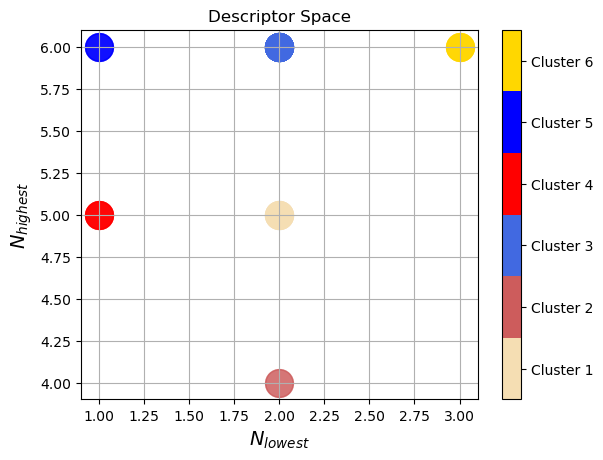

In [18]:
fig, ax = plt.subplots()
cls = dme.clustering(positions)
cpp = ClusterPlotter(cls)
cpp.descriptor_space_plot(dme, ax, fig)

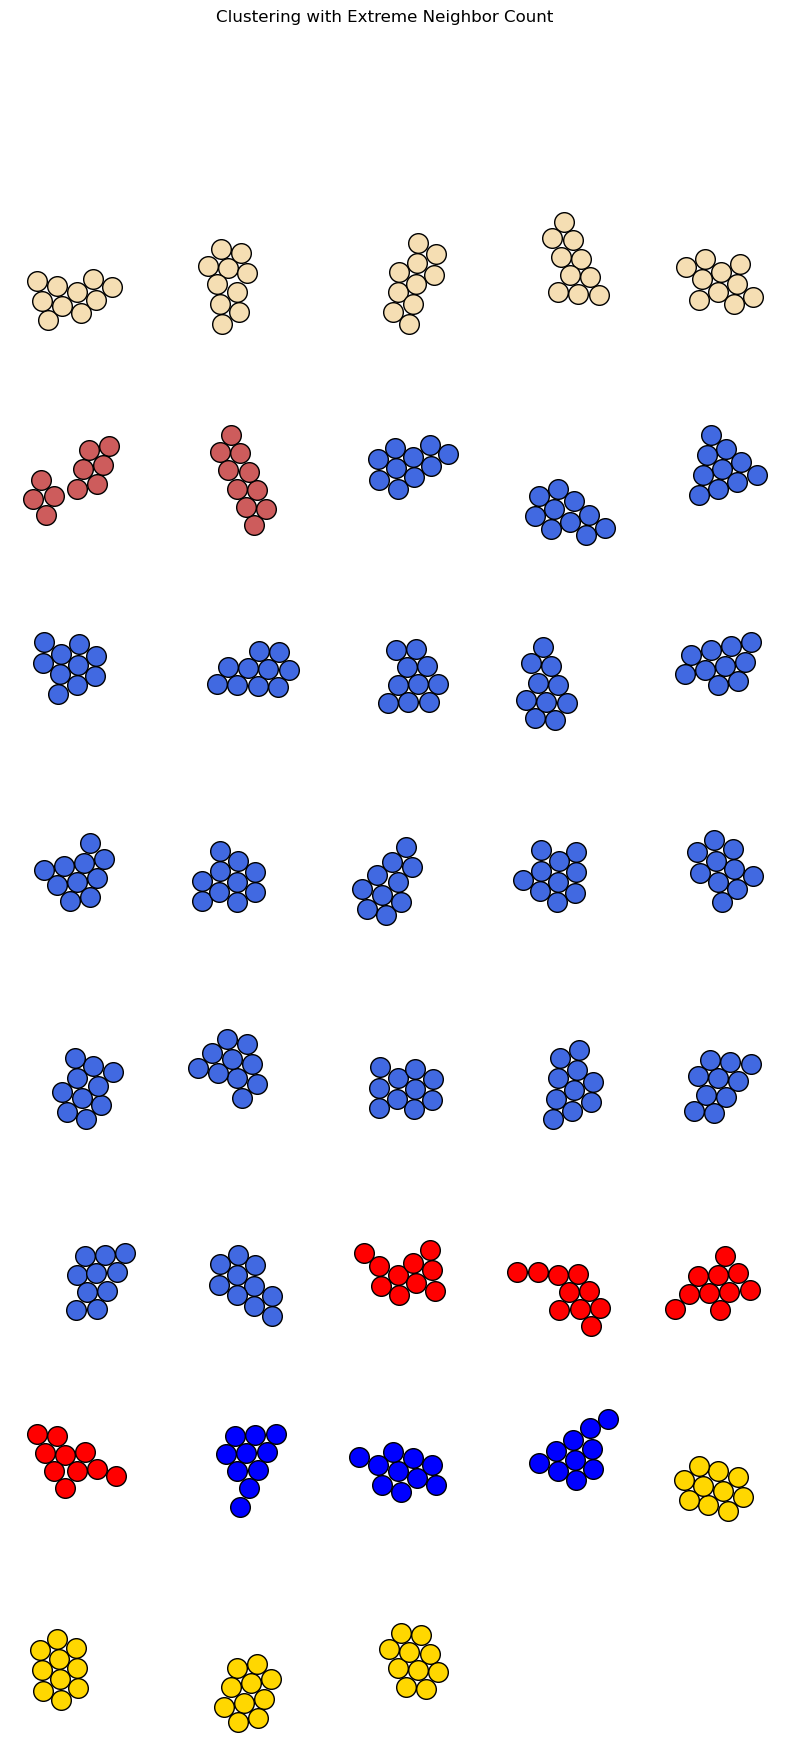

In [19]:
fig, axs = plt.subplots(8, 5, figsize=(10, 20))
fig.suptitle("Clustering with Extreme Neighbor Count")
clusters = dme.clustering(positions)
cpp = ClusterPlotter(clusters)
cpp.lj_plot(axs)

### Discussion

This looks somewhat more "rigorous". Elements of the same cluster seem more similar than with the Distance Moments representation.
However, there are still some clusters with many members, so clearly uniqueness is far from achieved with this representation

## Multidimensional Representations

### Interatomic Distance Distribution

This representation is based on the vector of histogram bar heights from the distribution of pairwise distances in the lj-cluster.

In [20]:
class PairDistances(Representation):
    
    def __init__(self, color='C1'):
        self.xwidth = 0.5
        self.color = color
        self.bin_edges = np.arange(0,7.01,self.xwidth)
        self.bin_centers = (self.bin_edges[:-1] + self.bin_edges[1:]) /2
    
    def descriptor(self,pos):
        all_distances = scipy.spatial.distance.pdist(pos)
        heights, edges = np.histogram(all_distances, bins=self.bin_edges)
        return heights
    
    def draw(self,pos,ax):
        vector = self.descriptor(pos)
        ax.bar(self.bin_centers,vector,width=0.8 * self.xwidth,color=self.color, edgecolor='k')
        ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))
        ax.set_title(self.__class__.__name__)
        ax.set_xlabel("Pairwise atomic distance")
        ax.set_ylabel("Counts")

### Coordination Number Profile

This representation is based on the vector of histogram bar heights from the distribution of the number of nearest neighbors

In [21]:
class CoordinationNumbers(Representation):
    
    def __init__(self, color='C2'):
        self.xwidth = 1
        self.color = color
    
    def descriptor(self,pos, sigma=2**(-1/6), A=1.2):
        all_distances = pdist(pos)
        r_cut = sigma*A*2**(1.0/6.0)
        Ns = []
        connectivity_matrix = (squareform(all_distances) <= r_cut).astype(int)
        np.fill_diagonal(connectivity_matrix, 0) #We set diagonal to zero, so that one particle is not counted as its own nearest neighbor
        for row in connectivity_matrix:
            Ns.append(sum(row))

        heights, bin_edges = np.histogram(Ns, bins=7)
        return heights
    
    def draw(self,pos,ax):
        vector = self.descriptor(pos)
        N = len(vector)
        xcenters = np.linspace(0,N-1,N) * self.xwidth
        ax.bar(xcenters,vector,width=0.8 * self.xwidth, color=self.color, edgecolor='k')
        ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))
        ax.set_title(self.__class__.__name__)
        ax.set_xlabel("No. of nearest neighbors")
        ax.set_ylabel("Counts")

### Connectivity Graph Spectrum

In this representation, we set up a connectivity matrix that describes whether pairs of atoms are nearest neighobors, M. We then find the eigenvalues of -M and let the representation be the vector of these (sorted) eigenvalues.

In [22]:
class ConnectivityGraphSpectrum(Representation):
    
    def __init__(self, color='C3'):
        self.xwidth = 1
        self.color = color
    
    def descriptor(self,pos, sigma=2**(-1/6), A=1.2):
        all_distances = pdist(pos)
        r_cut = sigma*A*2**(1.0/6.0)
        connectivity_matrix = -(squareform(all_distances) <= r_cut).astype(int)
        np.fill_diagonal(connectivity_matrix, 0) #We set diagonal to zero, so that one particle is not counted as its own nearest neighbor
        return np.sort(np.linalg.eig(connectivity_matrix)[0])
    def draw(self,pos,ax):
        vector = self.descriptor(pos)
        N = len(vector)
        xcenters = np.linspace(0,N-1,N) * self.xwidth
        ax.bar(xcenters,vector,width=0.8 * self.xwidth,color=self.color)
        ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))
        ax.set_title(self.__class__.__name__)
        ax.set_ylabel("Connectivity eigenvalue")
        ax.set_xlabel("Arb. eigenvalue label")


### Coulumb Matrix Spectrum

This representation is based on the matrix M with 1's in the diagonal, and $1/r_{ij}$ in the off-diagonal. The descriptor is the vector of eigenvalues of M.

In [23]:
class CoulombMatrixSpectrum(Representation):
    
    def __init__(self, color='C4'):
        self.xwidth = 1
        self.color = color
    
    def descriptor(self,pos, sigma=2**(-1/6), A=1.2):
        all_distances = pdist(pos)
        connectivity_matrix = (squareform(all_distances))
        np.fill_diagonal(connectivity_matrix, 1) #We set the diagonal elements to 1 for this representation
        connectivity_matrix = 1/connectivity_matrix
        return np.sort(np.linalg.eig(connectivity_matrix)[0])

    def draw(self,pos,ax):
        vector = self.descriptor(pos)
        N = len(vector)
        xcenters = np.linspace(0,N-1,N) * self.xwidth
        ax.bar(xcenters,vector,width=0.8 * self.xwidth,color=self.color)
        ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))
        ax.set_ylim([-2,8])
        ax.set_title(self.__class__.__name__)
        ax.set_ylabel("CoulumbMatrix eigenvalue")
        ax.set_xlabel("Arb. eigenvalue label")

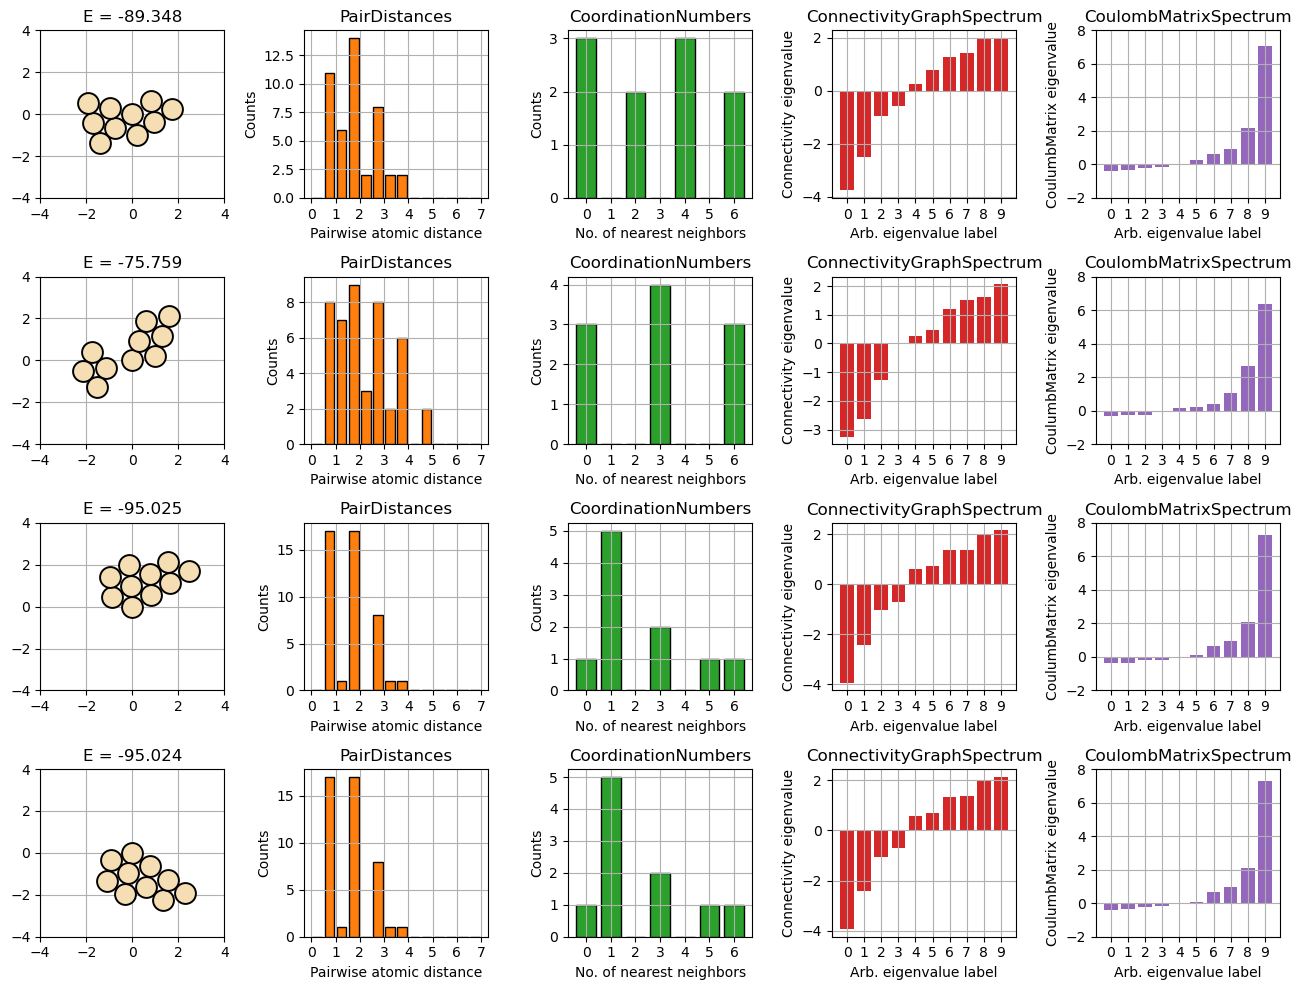

In [24]:
pd = PairDistances()
cn = CoordinationNumbers()
cg = ConnectivityGraphSpectrum()
cm = CoulombMatrixSpectrum()
fig, axs = plt.subplots(4, 5, figsize=(13, 10))
ClusterPlotter.descriptor_plot(positions, [pd, cn, cg, cm], axs)
fig.tight_layout()

## Principal Component Analysis

#### Here we choose some representation, and perform a Principal Component Analysis which reduces dimensionality in order to visualize descriptor-space

In [25]:
x = np.array([[1, 2, 3, 4, 5], [2, 4, 6, 8, 10]])

In [26]:
class PCA():

    def __init__(self, n_components=10):
        self._n = n_components
        self._components = np.array([])

    def center_X(self, X):
        mu = np.array([np.mean(X[:, i]) for i in range(X.shape[1])])
        mu_matrix = np.zeros(shape=X.shape)
        for i in range(len(mu)):
            mu_matrix[:, i] = mu[i]
        X_centered = X - mu_matrix
        return X_centered
    
    def fit(self, X): #X assumed to be M*p, M observations, p variables
        #Find Z
        if not isinstance(X, np.ndarray):
            raise TypeError("X Must be an ndarray")
        X_centered = self.center_X(X)

        #Covariance matrix
        cov = np.cov(X_centered, rowvar=False)
        #Eigenvalue decomposition of covariance matrix:
        eigvals, eigvecs = np.linalg.eigh(cov)
        indexes = eigvals.argsort()[::-1]
        eigvals = eigvals[indexes]
        eigvecs = eigvecs[:,indexes]
        self._components = eigvecs
        return self
    
    def transform(self, X):
        #Find principal components
        Z = np.matmul(self.center_X(X), self._components)
        #Limit to the first k components:
        Z_k = Z[:, :self._n]
        return Z_k
    def fit_and_transform(self, X):
        self.fit(X)
        return self.transform(X)

### PCA on an LJ-cluster

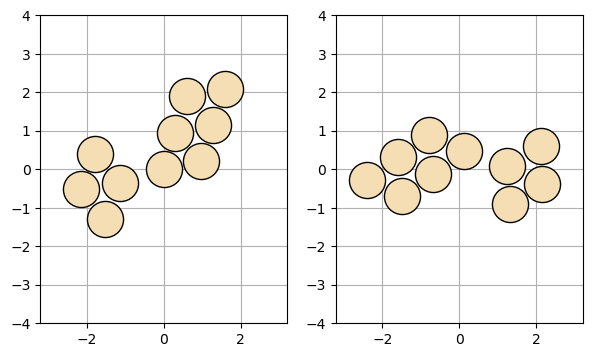

In [27]:
data = positions[1]
fig, ax = plt.subplots(1, 2, figsize=(7, 4))
ax[0].plot(data[:, 0], data[:, 1], "o", color="wheat", markeredgecolor='k', markersize=26)
pca = PCA()
new_data = pca.fit_and_transform(data)
ax[1].plot(new_data[:, 0], new_data[:, 1], "o", color="wheat", markeredgecolor='k', markersize=26)
ax[0].axis("equal")
ax[1].axis("equal")
ax[0].set_xlim(-4, 4)
ax[0].set_ylim(-4, 4)
ax[1].set_xlim(-4, 4)
ax[1].set_ylim(-4, 4)
ax[0].grid()
ax[1].grid()

#### We see that the cluster is rotated such that the direction of largest variance aligns with the first axis. Explanation: We simply use the 2D spatial coordinates as the representation for this LJ-cluster, and then perform PCA on these coordinates. The point of performing PCA is usually to reduce the dimensionality, by only choosing the first $k$ PCA-components. Thus, the transformed coordinates should be such that the first component (first axis in the plot) shows the most variance between the positions of the clusters, such that we may still distinguish differences from different data sets as much as possible, while, i.e., only choosing this first component to describe the data.

#### Usually we would use some ND-representation of the data instead, with a certain descriptor, and then perform the Principal Component Analysis on those. That is what we do in the following

## Relaxed atomic clusters

#### We use the Coulumb Matrix Spectrum representation

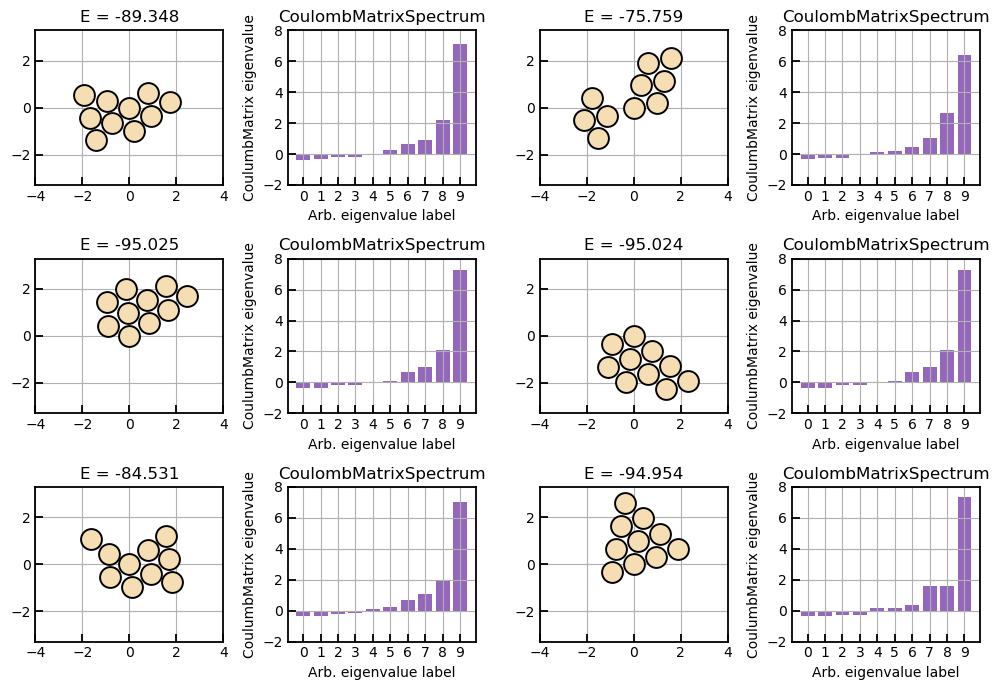

In [28]:
fig, axs = plt.subplots(3, 4, figsize=(10, 7))

cm = CoulombMatrixSpectrum()
ClusterPlotter.descriptor_plot(positions, cm, axs)
fig.tight_layout()

#### For all 38 LJ-clusters, the descriptor from the CoulumbMatrixSpectrum representation is collected, and transformed with by Principal Component analysis, down to 2 dimensions. Then the transformed descriptors are plotted.

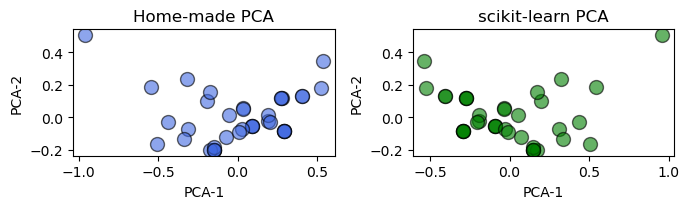

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(7, 2.2))
descriptors = []
for position in positions:
    des = cm.descriptor(position)
    descriptors.append(des)
transformed_descriptors = pca.fit_and_transform(np.array(descriptors))



sklearn_pca = decomposition.PCA(2)
alternative_transform = sklearn_pca.fit_transform(descriptors)
ax[0].plot(transformed_descriptors[:,0], transformed_descriptors[:, 1], "o", color="royalblue", alpha=0.6, markeredgecolor='k', markersize=10)
ax[1].plot(alternative_transform[:,0], alternative_transform[:, 1], "o", color="green", alpha=0.6, markeredgecolor='k', markersize=10)


for axx in ax:
    axx.set_xlabel("PCA-1")
    axx.set_ylabel("PCA-2")
ax[0].set_title("Home-made PCA")
ax[1].set_title("scikit-learn PCA")
fig.tight_layout()

#### Discussion

##### The results seem to be identical, except for the first axis being inverted. One curious thing is that the first axis is inverted, while the second is not.

##### This inversion is likely due to the diagonalization routine used. Eigenvectors can only be found up to a sign and a front factor, since an eigenvector multiplied by a scalar is still an eigenvector.

## Rattled Atomic Clusters

#### Now, we rattle some LJ-clusters and perform PCA on their Coulumb Matrix Spectrum representation, and compare their positions in descriptor space to their relaxed counterparts

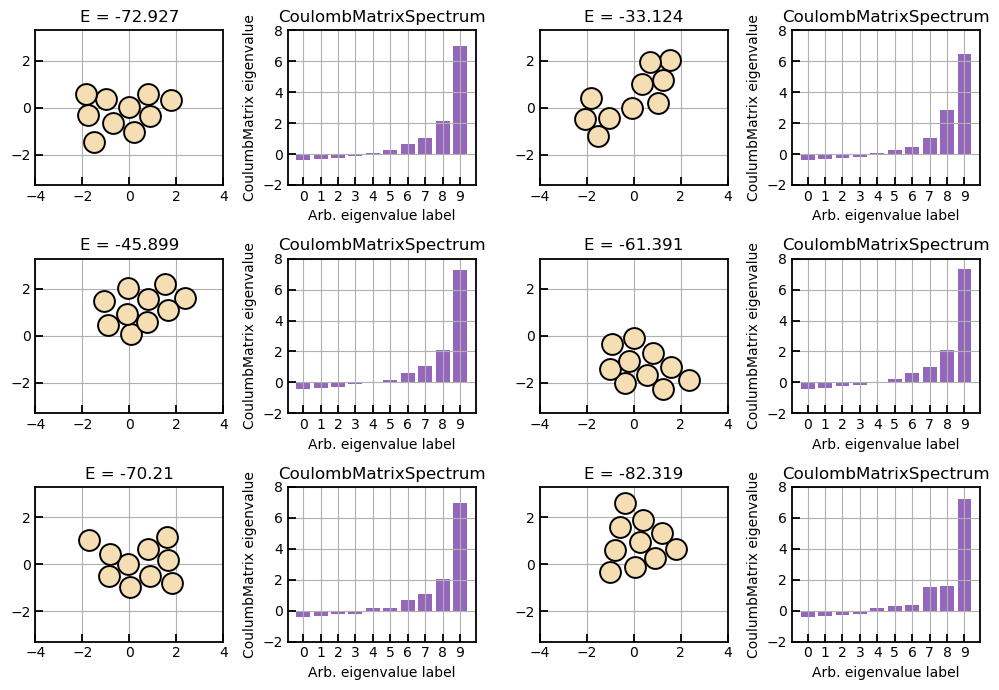

In [30]:
rattled_positions = []
for position in positions:
    rattled_position = []
    for p in position:
        p1 =p[0] + (np.random.rand()-0.5)*0.2
        p2 = p[1] + (np.random.rand()-0.5)*0.2
        rattled_position.append([p1, p2])
    rattled_positions.append(rattled_position)
rattled_positions = np.array(rattled_positions)


fig, axs = plt.subplots(3, 4, figsize=(10, 7))

cm = CoulombMatrixSpectrum()
ClusterPlotter.descriptor_plot(rattled_positions, cm, axs)
fig.tight_layout()

#### We plot the first six of the PCA-reduced descriptors for both the original and the rattled LJ-clusters, so that we may compare them
(The specific clusters are the same as those plotted above)

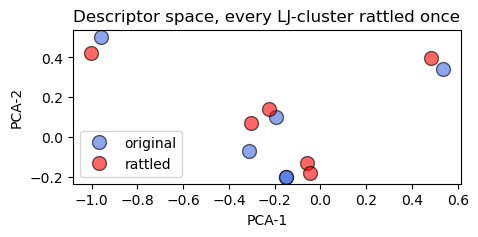

In [31]:
fig, ax = plt.subplots(figsize=(5, 2))

rattled_descriptors = []
for rattled in rattled_positions:
    rattled_descriptors.append(cm.descriptor(rattled))
transformed_rattled = pca.transform(np.array(rattled_descriptors))
ax.plot(transformed_descriptors[:6,0], transformed_descriptors[:6, 1], "o", color="royalblue", alpha=0.6, markeredgecolor='k', markersize=10, label="original")
ax.plot(transformed_rattled[:6,0], transformed_rattled[:6, 1], "o", color="red", alpha=0.6, markeredgecolor='k', markersize=10, label="rattled")
ax.set_title("Descriptor space, every LJ-cluster rattled once")
ax.set_xlabel("PCA-1")
ax.set_ylabel("PCA-2")
ax.legend()

#### Clearly, they appear somewhat in pairs, showing that this representation of the LJ-clusters will ensure that LJ-clusters that are similar but slightly different, will be in the vicinity of one another in descriptor space

#### We may also rattled one LJ-cluster many times and repeatedly plot it in descriptor-space:

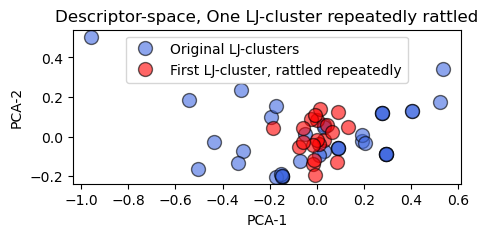

In [32]:
fig, ax = plt.subplots(figsize=(5, 2))
rattles = []
for i in range(20):
    pos = positions[0]
    r = []
    for p in pos:
        p1 = p[0] + (np.random.rand()-0.5)*0.2
        p2 = p[1] + (np.random.rand()-0.5)*0.2
        r.append([p1, p2])
    rattles.append(r)
rattles = np.array(rattles)
rattles_des = []
for rattled in rattles:
    rattles_des.append(cm.descriptor(rattled))
transformed_rattles = pca.transform(np.array(rattles_des))
ax.plot(transformed_descriptors[:,0], transformed_descriptors[:, 1], "o", color="royalblue", alpha=0.6, markeredgecolor='k', markersize=10, label="Original LJ-clusters")
ax.plot(transformed_rattles[:,0], transformed_rattles[:, 1], "o", color="red", alpha=0.6, markeredgecolor='k', markersize=10, label="First LJ-cluster, rattled repeatedly")
ax.set_title("Descriptor-space, One LJ-cluster repeatedly rattled")
ax.set_xlabel("PCA-1")
ax.set_ylabel("PCA-2")
ax.legend()

### Discussion

#### We see that the rattled versions of the LJ-cluster remain close to one another in descriptor space. This implies that we may assume clusters close in descriptor space to be similar in their spatial configuration, which allows us to perform clustering with the use of this PCA-reduced descriptor.

## KMeans Clustering in 2D

#### KMeans is a method of clustering which shall be implemented here, to be performed with our PCA-reduced Coulumb Matrix Spectrum representation.

#### The method simply minimizes the distances in descriptor space for the cluster members to an assigned centroid of the cluster

#### There are two primary methods. The first fits to a dataset, and establishes a given number of clusters based on the fitting. The second method receives yet another data set, and places this data onto the established clusters

In [33]:
class KMeans:
    def __init__(self, n_clusters, max_iter=100, tol=1e-4):
        self._n = n_clusters
        self._clusters = [] #Clusters of data points
        self._centroids = []

        self._max_iter = max_iter
        self._tol = tol

    def fit(self, X):
        n_centroids = []
        for i in range(self._n):
            n_centroids.append([(np.random.rand())*(X[:, k].max() - X[:, k].min()) + X[:, k].min() for k in range(len(X[0]))])
        self._centroids = n_centroids

        old_clusters = self.assign_to_clusters(X)
        #Iteratively assign datapoints to clusters and subsequently update the centroids:
        itera = 0
        while itera < self._max_iter:
            self.update_centroids(old_clusters)
            current_clusters = self.assign_to_clusters(X)
            if current_clusters == old_clusters:
                print("Convergence! Updated clusters are the same as before!")
                self._clusters = current_clusters
                break
            else:
                old_clusters = current_clusters
                itera += 1

    def assign_to_clusters(self, X):
        #Assign each datapoint to a cluster
        clusters = []
        for i in range(self._n):
            clusters.append([])
        for datapoint in X:
            min_dist = 1e30
            best_centroid_index = None
            for centroid, index in zip(self._centroids, range(self._n)):
                dist = sum([(datapoint[k] - centroid[k])**2 for k in range(len(datapoint))])
                if dist <= min_dist:
                    min_dist = dist
                    best_centroid_index = index
            clusters[best_centroid_index].append([datapoint[k] for k in range(len(datapoint))])
        clusters = clusters
        return clusters
    
    def update_centroids(self, clusters):
        #Update centroids
        for index in range(self._n):
            if len(clusters[index]) != 0:
                this_mean = [1/len(clusters[index])*sum([c[k] for c in clusters[index]]) for k in range(len(clusters[index][0]))]
                #this_mean[0] = 1/len(clusters[index])*sum([c[0] for c in clusters[index]])
                #this_mean[1] = 1/len(clusters[index])*sum([c[1] for c in clusters[index]])
                self._centroids[index] = this_mean

    def predict(self, X):
        indexes = []
        for datapoint in X:
            min_dist = 1e30
            best_centroid_index = None
            for centroid, index in zip(self._centroids, range(self._n)):
                dist = (datapoint[0] - centroid[0])**2 + (datapoint[1] - centroid[1])**2
                if dist <= min_dist:
                    min_dist = dist
                    best_centroid_index = index
            indexes.append(best_centroid_index)
        return indexes

#### Testing the class:

Convergence! Updated clusters are the same as before!


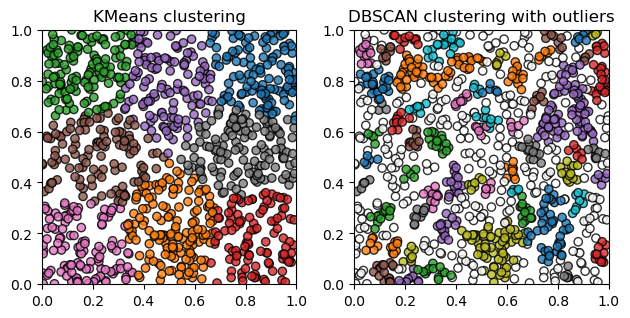

In [34]:
fig, axs = plt.subplots(1, 2)

X = np.random.rand(1000, 2)  # 1000 data points, 2 features
kmeans = KMeans(n_clusters=8)
kmeans.fit(X)
labels = kmeans.predict(X)
axs[0].scatter(X[:,0],X[:,1],c=[f'C{l}' for l in labels], edgecolor='k', alpha=0.8)
axs[0].set_title("KMeans clustering")
for ax in axs:
    ax.set_aspect('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)


scikit_kmeans = cluster.DBSCAN(eps=3.3e-2, min_samples=5)
labels2 = scikit_kmeans.fit_predict(X)
axs[1].scatter(X[:,0],X[:,1],c=[f'C{l}' if l != -1 else f"white" for l in labels2], edgecolor='k', alpha=0.8)
axs[1].set_title("DBSCAN clustering with outliers")
fig.tight_layout()


### Discussion:

##### Points about DBSCAN:

##### eps-parameter: Gives the distance that two points can have from one another and still be considered in the neighborhood of one another. The larger, the less variation of clusters -> Very large, and everything is just one cluster. Too small, and everything is considered an outlier. According to scikit-learn, this is the most important parameter to choose appropriately to ones data set

##### min_samples -> Seems to increase the number of outliers when increasing min_samples. It sets a stricter requirement for a point to be considered a core point. Explanation from scikit-learn: "If min_samples is set to a higher value, DBSCAN will find denser clusters, whereas if it is set to a lower value, the found clusters will be more sparse."

## Coulumb Matrix Spectrum + PCA

No handles with labels found to put in legend.


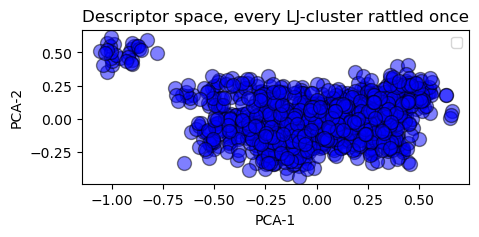

In [35]:
relaxed_clusters = positions
rattled_clusters = []
for i in range(30): # We make 30 rattled instances of every LJ-cluster
    for position in positions:
        rattled_position = []
        for p in position:
            p1 =p[0] + (np.random.rand()-0.5)*0.2
            p2 = p[1] + (np.random.rand()-0.5)*0.2
            rattled_position.append([p1, p2])
        rattled_clusters.append(rattled_position)
rattled_clusters = np.array(rattled_clusters)
fig, ax = plt.subplots(figsize=(5, 2))
rattled_clusters_descriptors = []
for rattled in rattled_clusters:
    rattled_clusters_descriptors.append(cm.descriptor(rattled))
transformed_clusters_rattled = pca.transform(np.array(rattled_clusters_descriptors))
ax.plot(transformed_clusters_rattled[:,0], transformed_clusters_rattled[:, 1], "o", color="blue", alpha=0.5, markeredgecolor='k', markersize=10)
ax.set_title("Descriptor space, every LJ-cluster rattled once")
ax.set_xlabel("PCA-1")
ax.set_ylabel("PCA-2")
ax.legend()


#### Now we perform a KMeans clustering on the full 10D CoulumbMatrixSpectrum descriptor, after which we plot the first two dimensions of the descriptors after a PCA-transformation, where all LJ-clusters are labeled according to the cluster that they belong to

Convergence! Updated clusters are the same as before!


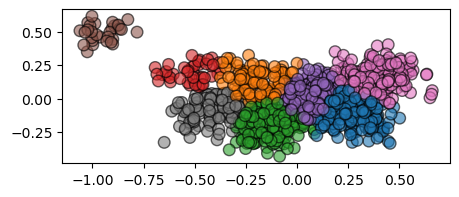

In [36]:
fig, ax = plt.subplots(figsize=(5, 2))
no_of_clusters = 8
kmeans2 = KMeans(n_clusters=no_of_clusters)
kmeans2.fit(transformed_clusters_rattled) #We use the full, 10D-descriptors to perform KMeans
labels_final = kmeans2.predict(transformed_clusters_rattled)

#The First 2 PCA-dimensions are plotted, wich the clusters labeled
ax.scatter(transformed_clusters_rattled[:,0],transformed_clusters_rattled[:,1],c=[f'C{l}' for l in labels_final], edgecolor='k', alpha=0.6, s=70)

#### Finally, we plot some of these lj-clusters, color coded to show which clusters they belong to from the above plot

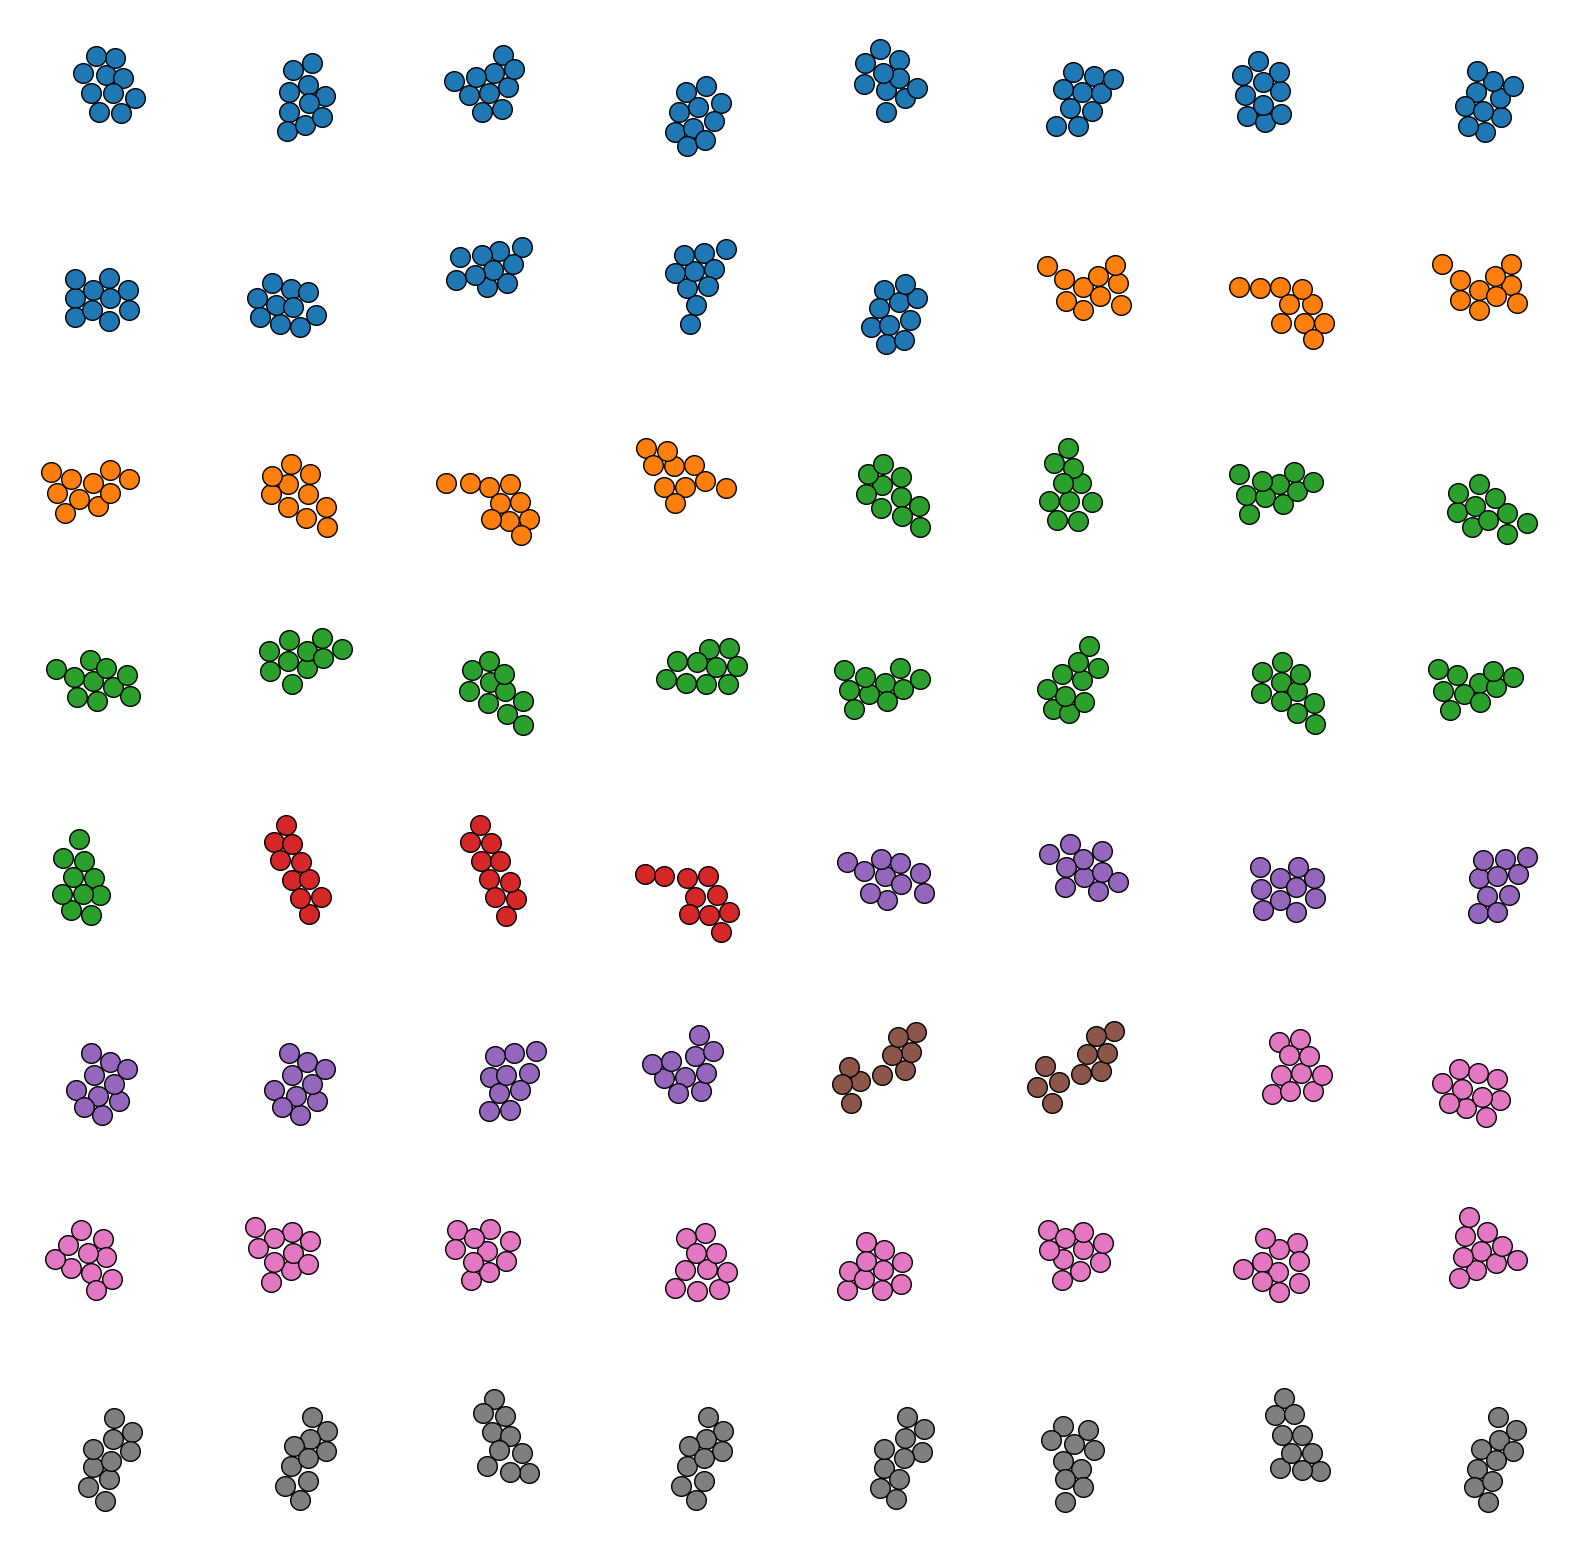

In [92]:
fig, axs = plt.subplots(8, 8, figsize=(20, 20))
rattled_groups = [Cluster([]) for k in range(no_of_clusters)]
for i in range(64):
    index = int(np.random.rand()*1000)
    rattled_groups[labels_final[index]].add_lj_cluster(rattled_clusters[index])
cols = [f"C{k}" for k in range(no_of_clusters)]
plotter = ClusterPlotter(rattled_groups, colors=cols)
plotter.lj_plot(axs)

